In [1]:
from itertools import chain
import pyalex
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

# monkey patch pyalex.Work to implement __hash__ (using id)
def custom_hash(self):
    return id(self)


pyalex.Work.__hash__ = custom_hash


def get_referenced_publications(openalex_id: str, require_abstract=False) -> set[pyalex.Work]:
    referenced_publications = set()
    publication = pyalex.Works()[openalex_id]
    reference_ids = set(publication["referenced_works"])
    reference_ids = ["W" + reference.split("W")[-1] for reference in
                     reference_ids]  # use shortened ids because query gets too long otherwise 
    for i in range(0, len(reference_ids), 100):
        query = (
            pyalex.Works()
            .filter(openalex="|".join(reference_ids[i: i + 100]))
        )        
        if require_abstract:
            query = query.filter(has_abstract=True)
            
        for pyalex_work in chain(*query.paginate(per_page=100, n_max=100)):
            if pyalex_work["id"] != "https://openalex.org/W4285719527":  # deleted works are represented by this dummy entity
                referenced_publications.add(pyalex_work)
                
        return referenced_publications

def get_referenced_publications_in_corpus(openalex_ids: list[str]) -> dict[str, set[pyalex.Work]]:
    referenced_publications_in_corpus = {}
    for query_id in openalex_ids:
        referenced_publications_in_corpus[query_id] = get_referenced_publications(query_id)
    return referenced_publications_in_corpus

In [2]:
import pandas as pd
df = pd.read_pickle("eval_reranking_results.pkl")

In [3]:
df.columns

Index(['run', 'type', 'query_work', 'result_work', 'result_rank',
       'common_references', 'max_common_references', 'ratio_common_references',
       'is_reference_of_citing_work'],
      dtype='object')

In [4]:
df

,run,type,query_work,result_work,result_rank,common_references,max_common_references,ratio_common_references,is_reference_of_citing_work
0,0,retrieval,https://openalex.org/W316998542,https://openalex.org/W3216146155,1,0,41,0.000000,False
1,0,retrieval,https://openalex.org/W316998542,https://openalex.org/W1995297089,2,0,41,0.000000,True
2,0,retrieval,https://openalex.org/W316998542,https://openalex.org/W3001733563,3,0,41,0.000000,False
3,0,retrieval,https://openalex.org/W316998542,https://openalex.org/W2134582745,4,0,41,0.000000,True
4,0,retrieval,https://openalex.org/W316998542,https://openalex.org/W2138807703,5,1,39,0.025641,True
...,...,...,...,...,...,...,...,...,...
19995,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W3185871335,96,6,15,0.400000,True
19996,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W2762229885,97,1,23,0.043478,True
19997,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W2987037502,98,0,0,NaN,True
19998,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W4223630566,99,0,29,0.000000,True


In [5]:
retrieval = df[df["type"] == "retrieval"]
reranking = df[df["type"] == "reranking"]
retrieval_top10 = retrieval[retrieval["result_rank"] <= 10]
reranking_top10 = reranking[reranking["result_rank"] <= 10]
retrieval_top10

,run,type,query_work,result_work,result_rank,common_references,max_common_references,ratio_common_references,is_reference_of_citing_work
0,0,retrieval,https://openalex.org/W316998542,https://openalex.org/W3216146155,1,0,41,0.000000,False
1,0,retrieval,https://openalex.org/W316998542,https://openalex.org/W1995297089,2,0,41,0.000000,True
2,0,retrieval,https://openalex.org/W316998542,https://openalex.org/W3001733563,3,0,41,0.000000,False
3,0,retrieval,https://openalex.org/W316998542,https://openalex.org/W2134582745,4,0,41,0.000000,True
4,0,retrieval,https://openalex.org/W316998542,https://openalex.org/W2138807703,5,1,39,0.025641,True
...,...,...,...,...,...,...,...,...,...
19805,99,retrieval,https://openalex.org/W4386898729,https://openalex.org/W3113171896,6,1,19,0.052632,False
19806,99,retrieval,https://openalex.org/W4386898729,https://openalex.org/W3176832074,7,7,56,0.125000,False
19807,99,retrieval,https://openalex.org/W4386898729,https://openalex.org/W2793826339,8,1,32,0.031250,True
19808,99,retrieval,https://openalex.org/W4386898729,https://openalex.org/W3138004978,9,1,32,0.031250,False


In [6]:
reranking_top10

,run,type,query_work,result_work,result_rank,common_references,max_common_references,ratio_common_references,is_reference_of_citing_work
100,0,reranking,https://openalex.org/W316998542,https://openalex.org/W2104830066,1,6,41,0.146341,True
101,0,reranking,https://openalex.org/W316998542,https://openalex.org/W2134582745,2,0,41,0.000000,True
102,0,reranking,https://openalex.org/W316998542,https://openalex.org/W2138807703,3,1,39,0.025641,True
103,0,reranking,https://openalex.org/W316998542,https://openalex.org/W1971636989,4,7,41,0.170732,True
104,0,reranking,https://openalex.org/W316998542,https://openalex.org/W2106515248,5,0,0,NaN,True
...,...,...,...,...,...,...,...,...,...
19905,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W3001288491,6,0,0,NaN,True
19906,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W4280565316,7,7,43,0.162791,False
19907,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W3214152447,8,0,0,NaN,True
19908,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W3201110970,9,4,21,0.190476,True


In [7]:
referenced_publications_in_corpus = get_referenced_publications_in_corpus(df["query_work"].unique())

## ratio of retrieved query work references to the total number of query work references in corpus

In [14]:
# ratio of retrieved query work references to the total number of query work references in corpus
def get_ratio_retrieved_references(df: pd.DataFrame) -> NDArray[np.float64]:
    ratio_retrieved_references = []
    num_runs = df["run"].max()
    for i in range(num_runs + 1):
        query_work_id = df[df["run"] == i]["query_work"].iloc[0]
        num_retrieved_references = df[df["run"] == i]["is_reference_of_citing_work"].sum()
        ratio_retrieved_references.append(num_retrieved_references / len(referenced_publications_in_corpus[query_work_id]))

    return np.array(ratio_retrieved_references)

# test for normal distribution of differences
import scipy.stats as stats
def test_normal_distribution(retrieval: NDArray[np.float64], reranking: NDArray[np.float64]) -> None:
    difference = reranking - retrieval
    print(stats.wilcoxon(difference))
    # box plot
    plt.boxplot(difference)  

WilcoxonResult(statistic=747.0, pvalue=1.6683522796883337e-07)


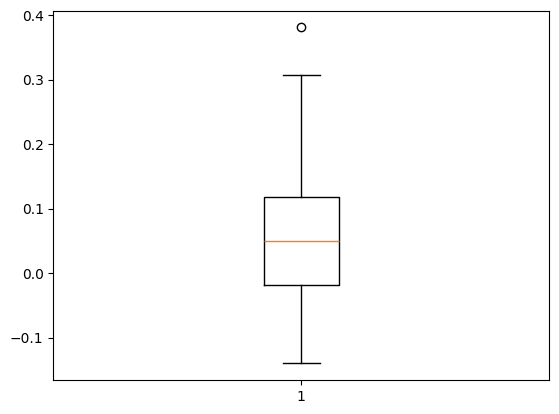

In [15]:
# ratio of retrieved query work references to the total number of query work references in corpus
ratio_retrieved_references_retrieval = get_ratio_retrieved_references(retrieval_top10)
ratio_retrieved_references_reranking = get_ratio_retrieved_references(reranking_top10)

test_normal_distribution(ratio_retrieved_references_retrieval, ratio_retrieved_references_reranking)

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison(retrieval_stats: NDArray[np.float64], reranking_stats: NDArray[np.float64], title: str, xlabel: str, ylabel: str) -> None:
    save_path = "/home/fs/thesis/thesis/figures/"
    
    retrieval_color = "dimgrey"
    reranking_color = "crimson"
    mean_label_color = "black"
    difference_color = "lightblue"
    
    font_size = 36
    font_size_ticks = 28
    font_size_legend = 24
    x_ticks_rotation = 0
    x_ticks_interval = 10 if xlabel == "Run" else 1
    bar_width = 0.4
    
    mean_label_x = -4.5 if ylabel != "RMRCR" else -0.85
    mean_label_y_offset = 0.01 if ylabel != "RMRCR" else 0.005
    
    len_stats = len(retrieval_stats)    
    
    difference = np.array(reranking_stats) - np.array(retrieval_stats)
    mean_difference = np.nanmean(difference)
    
    # Plot 1: Bar chart comparison
    mean_retrieval = np.nanmean(retrieval_stats)
    mean_reranking = np.nanmean(reranking_stats)
    
    # dont show last plot if xlabel = "Rank" as it is not meaningful
    if xlabel == "Rank":
        plt.figure(figsize=(40, 15))
        # plt.title(title, fontsize=25)
        x_ticks = [0] + list(range(9, len_stats, x_ticks_interval))
        plt.xticks(x_ticks, [f"{i+1}" for i in x_ticks], fontsize=font_size_ticks, rotation=x_ticks_rotation)
        plt.xlabel(f"{xlabel}", fontsize=font_size)
        plt.yticks(fontsize=font_size_ticks)
        plt.ylabel(ylabel, fontsize=font_size)    
    
        plt.bar([x - 0.5 * bar_width for x in range(len_stats)], retrieval_stats, width=0.4, label='Pre-Reranking', align='center', color=retrieval_color)
        plt.bar([x + 0.5 * bar_width for x in range(len_stats)], reranking_stats, width=0.4, label='Post-Reranking', align='center', color=reranking_color)    

        # plot linear regression line
        x = np.arange(len_stats) # extend trend line beyond the data points
        trend = np.polyfit(np.arange(len_stats), retrieval_stats, 1)
        retrieval_trend_line = np.polyval(trend, x)
        plt.plot(x, retrieval_trend_line, color=retrieval_color, linestyle='--', linewidth=4, label="Trend (Pre-Reranking)")
        trend = np.polyfit(np.arange(len_stats), reranking_stats, 1)
        reranking_trend_line = np.polyval(trend, x)
        plt.plot(x, reranking_trend_line, color=reranking_color, linestyle='--', linewidth=4, label="Trend (Pro-Reranking)")
    
        plt.legend(fontsize=font_size - 4, loc='upper right')
        plt.savefig(f"{save_path}/{ylabel}.svg", format="svg", bbox_inches='tight')
        plt.show()    
    
    
    else:
        # Plot 3: Sorted bar chart comparison
        sort_idx_retrieval = np.argsort(retrieval_stats)[::-1]
        sort_idx_reranking = np.argsort(reranking_stats)[::-1]
        sorted_retrieval_stats = retrieval_stats[sort_idx_retrieval]
        sorted_reranking_stats = reranking_stats[sort_idx_reranking]
        
        plt.figure(figsize=(40, 15))
        # plt.title(title, fontsize=25)
        x_ticks = np.arange(len(retrieval_stats))
        # plt.xticks(x_ticks, fontsize=14, rotation=45)
        # plt.xlabel(f"Idx, sorted by {ylabel} (descending)", fontsize=font_size)
        plt.xticks([])
        plt.yticks(fontsize=font_size_ticks)
        plt.ylabel(f"{ylabel}", fontsize=font_size)
        plt.bar(x_ticks - bar_width/2, sorted_retrieval_stats, width=bar_width, label='Pre-Reranking', align='center', color=retrieval_color)
        plt.bar(x_ticks + bar_width/2, sorted_reranking_stats, width=bar_width, label='Post-Reranking', align='center', color=reranking_color)
        # also plot horizontal lines for mean of both retrieval and reranking
        plt.axhline(mean_retrieval, color=retrieval_color, linewidth=2, label="Mean (Pre-Reranking)")
        plt.axhline(mean_reranking, color=reranking_color, linewidth=2, label="Mean (Post-Reranking)")
        # plot the mean values next to the vertical axis
        plt.text(x=mean_label_x, y=mean_retrieval + mean_label_y_offset, s=f'{mean_retrieval:.3f}', color=mean_label_color, va='center', ha='left', fontsize=font_size_ticks)
        plt.text(x=mean_label_x, y=mean_reranking + mean_label_y_offset, s=f'{mean_reranking:.3f}', color=mean_label_color, va='center', ha='left', fontsize=font_size_ticks)
        plt.legend(fontsize=font_size, loc='upper right')
        plt.savefig(f"{save_path}/{ylabel}_sorted.svg", format="svg", bbox_inches='tight')
        plt.show()
        
        # Plot 4: Box plot comparison
        plt.figure(figsize=(20, 10))
        boxplot = plt.boxplot(
            [retrieval_stats, reranking_stats, difference],
            labels=['Pre-Reranking', 'Post-Reranking', 'Absolute Increase'],
            patch_artist=True,
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black')
        )
        
        # Customizing each box with a specific color
        colors = [retrieval_color, reranking_color, difference_color]
        for patch, color in zip(boxplot['boxes'], colors):
            patch.set_facecolor(color)
        
        # plt.title(f"Box Plot of {ylabel} for Retrieval, Reranking, and Difference", fontsize=font_size)
        plt.ylabel(ylabel, fontsize=font_size)
        plt.xticks(fontsize=font_size_ticks)
        plt.yticks(fontsize=font_size_ticks)
        plt.savefig(f"{save_path}/{ylabel}_boxplot.svg", format="svg", bbox_inches='tight')
        plt.show()

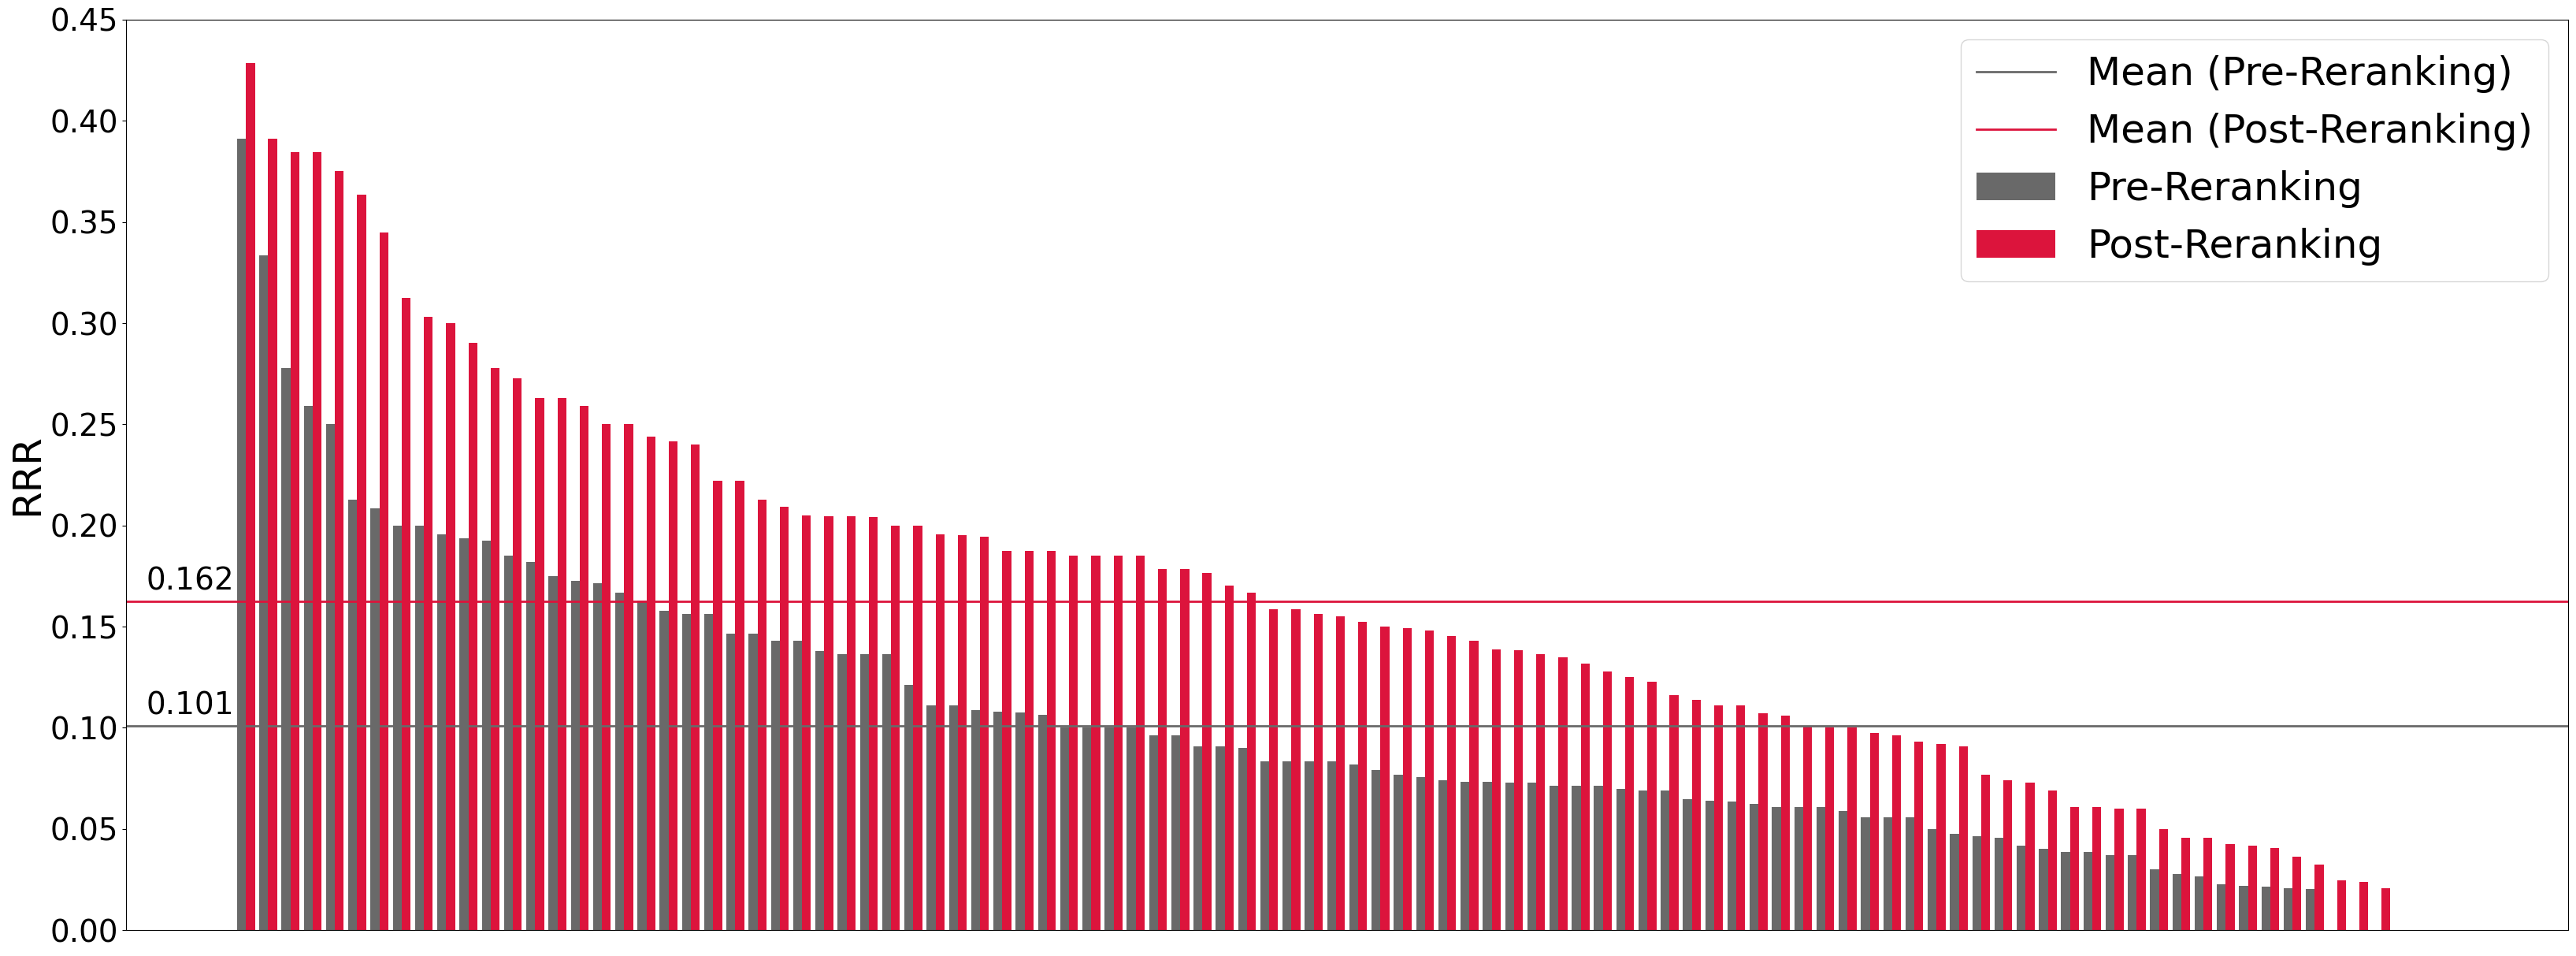

/tmp/ipykernel_60601/2791433123.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


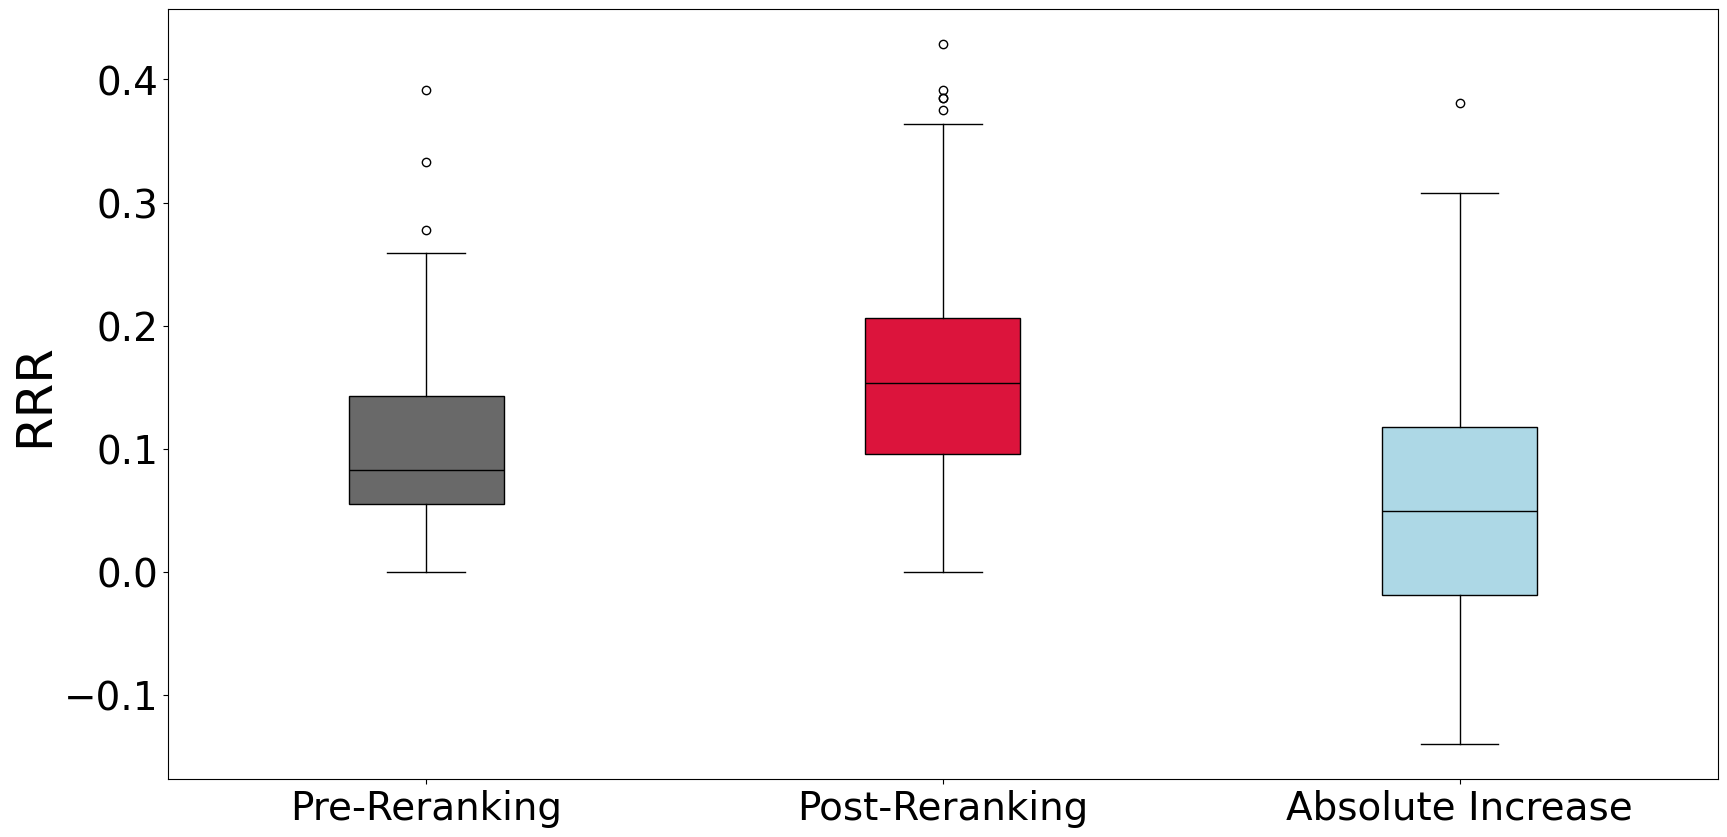

In [37]:
plot_comparison(ratio_retrieved_references_retrieval, ratio_retrieved_references_reranking, title="Ratio of Retrieved References", xlabel="Run", ylabel="RRR")

        ## ratio of common references between query work and each retrieved work
    for each combination of query work and corresponding retrieved work, the ratio is computed as: common_references / max_possible_common_references \
    where max_possible_common_references = min(query_references, retrieved_references), and common_references is the size of the intersection of the two sets
    
    for a ratio of 1.0, all references of either query or retrieved work are also referenced by the other\
    for a ratio of NaN, max_possible_common_references is 0, which means the retrieved work has no references

In [46]:
reranking_top10

,run,type,query_work,result_work,result_rank,common_references,max_common_references,ratio_common_references,is_reference_of_citing_work
100,0,reranking,https://openalex.org/W316998542,https://openalex.org/W2104830066,1,6,41,0.146341,True
101,0,reranking,https://openalex.org/W316998542,https://openalex.org/W2134582745,2,0,41,0.000000,True
102,0,reranking,https://openalex.org/W316998542,https://openalex.org/W2138807703,3,1,39,0.025641,True
103,0,reranking,https://openalex.org/W316998542,https://openalex.org/W1971636989,4,7,41,0.170732,True
104,0,reranking,https://openalex.org/W316998542,https://openalex.org/W2106515248,5,0,0,NaN,True
...,...,...,...,...,...,...,...,...,...
19905,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W3001288491,6,0,0,NaN,True
19906,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W4280565316,7,7,43,0.162791,False
19907,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W3214152447,8,0,0,NaN,True
19908,99,reranking,https://openalex.org/W4386898729,https://openalex.org/W3201110970,9,4,21,0.190476,True


In [20]:
def get_ratio_common_references(df: pd.DataFrame) -> NDArray[np.float64]:      
    ratio_common_references = []
    num_runs = df["run"].max()
    for i in range(num_runs + 1):
        run_results = df[df["run"] == i]
        # sort by rank
        run_results = run_results.sort_values(by="result_rank")
        ratios = run_results["ratio_common_references"].to_numpy()
        ratio_common_references.append(ratios)        
        
    return np.array(ratio_common_references)

def get_mean_ratio_common_references_per_run(ratio_common_references: NDArray[np.float64]) -> NDArray[np.float64]:
    return np.nanmean(ratio_common_references, axis=1)

def get_mean_ratio_common_references_per_rank(ratio_common_references: NDArray[np.float64]) -> NDArray[np.float64]:
    return np.nanmean(ratio_common_references, axis=0)

def get_mean_ratio_common_references_total(ratio_common_references: NDArray[np.float64]) -> NDArray[np.float64]:
    return np.nanmean(ratio_common_references)

def get_median_ratio_common_references_total(ratio_common_references: NDArray[np.float64]) -> NDArray[np.float64]:
    return np.nanmedian(ratio_common_references)

In [21]:
ratio_common_references_retrieval = get_ratio_common_references(retrieval_top10)
ratio_common_references_reranking = get_ratio_common_references(reranking_top10)
ratio_common_references_reranking

array([[0.14634146, 0.        , 0.02564103, 0.17073171,        nan,
        0.09756098, 0.14285714,        nan, 0.04878049, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ,        nan, 0.        , 0.        ],
       [0.13793103, 0.83333333,        nan, 0.5       , 0.12      ,
        0.34482759, 0.16666667, 0.5       , 0.125     , 0.27586207],
       [0.        , 0.        ,        nan, 0.07142857, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.17073171, 0.24390244, 0.15384615, 0.26829268, 0.12121212,
        0.09375   , 0.22727273, 0.52631579, 0.        , 0.04878049],
       [0.375     , 0.15625   , 0.8       , 0.15625   , 0.13043478,
        0.09375   , 0.21875   ,        nan, 0.        , 0.03571429],
       [       nan,        nan,        nan, 0.07142857,        nan,
        0.        , 0.        , 0.        , 0.        ,        nan],
       [0.07894737, 0.03571429, 0.       

### ratio of common references, per run
mean ratio of common references, per run (ignoring NaN values)

WilcoxonResult(statistic=231.0, pvalue=7.462948655134664e-15)


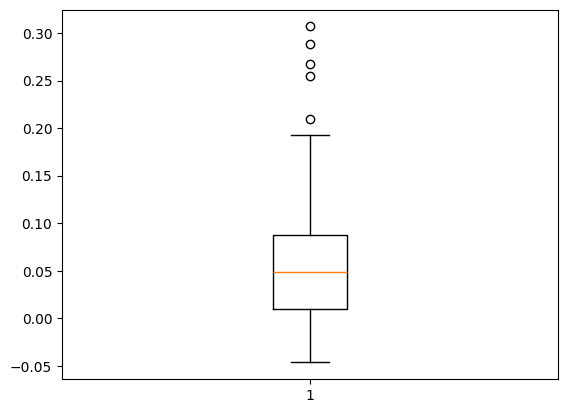

In [38]:
mean_ratio_common_references_per_run_reranking = get_mean_ratio_common_references_per_run(ratio_common_references_reranking)
mean_ratio_common_references_per_run_retrieval = get_mean_ratio_common_references_per_run(ratio_common_references_retrieval)
test_normal_distribution(mean_ratio_common_references_per_run_retrieval, mean_ratio_common_references_per_run_reranking)

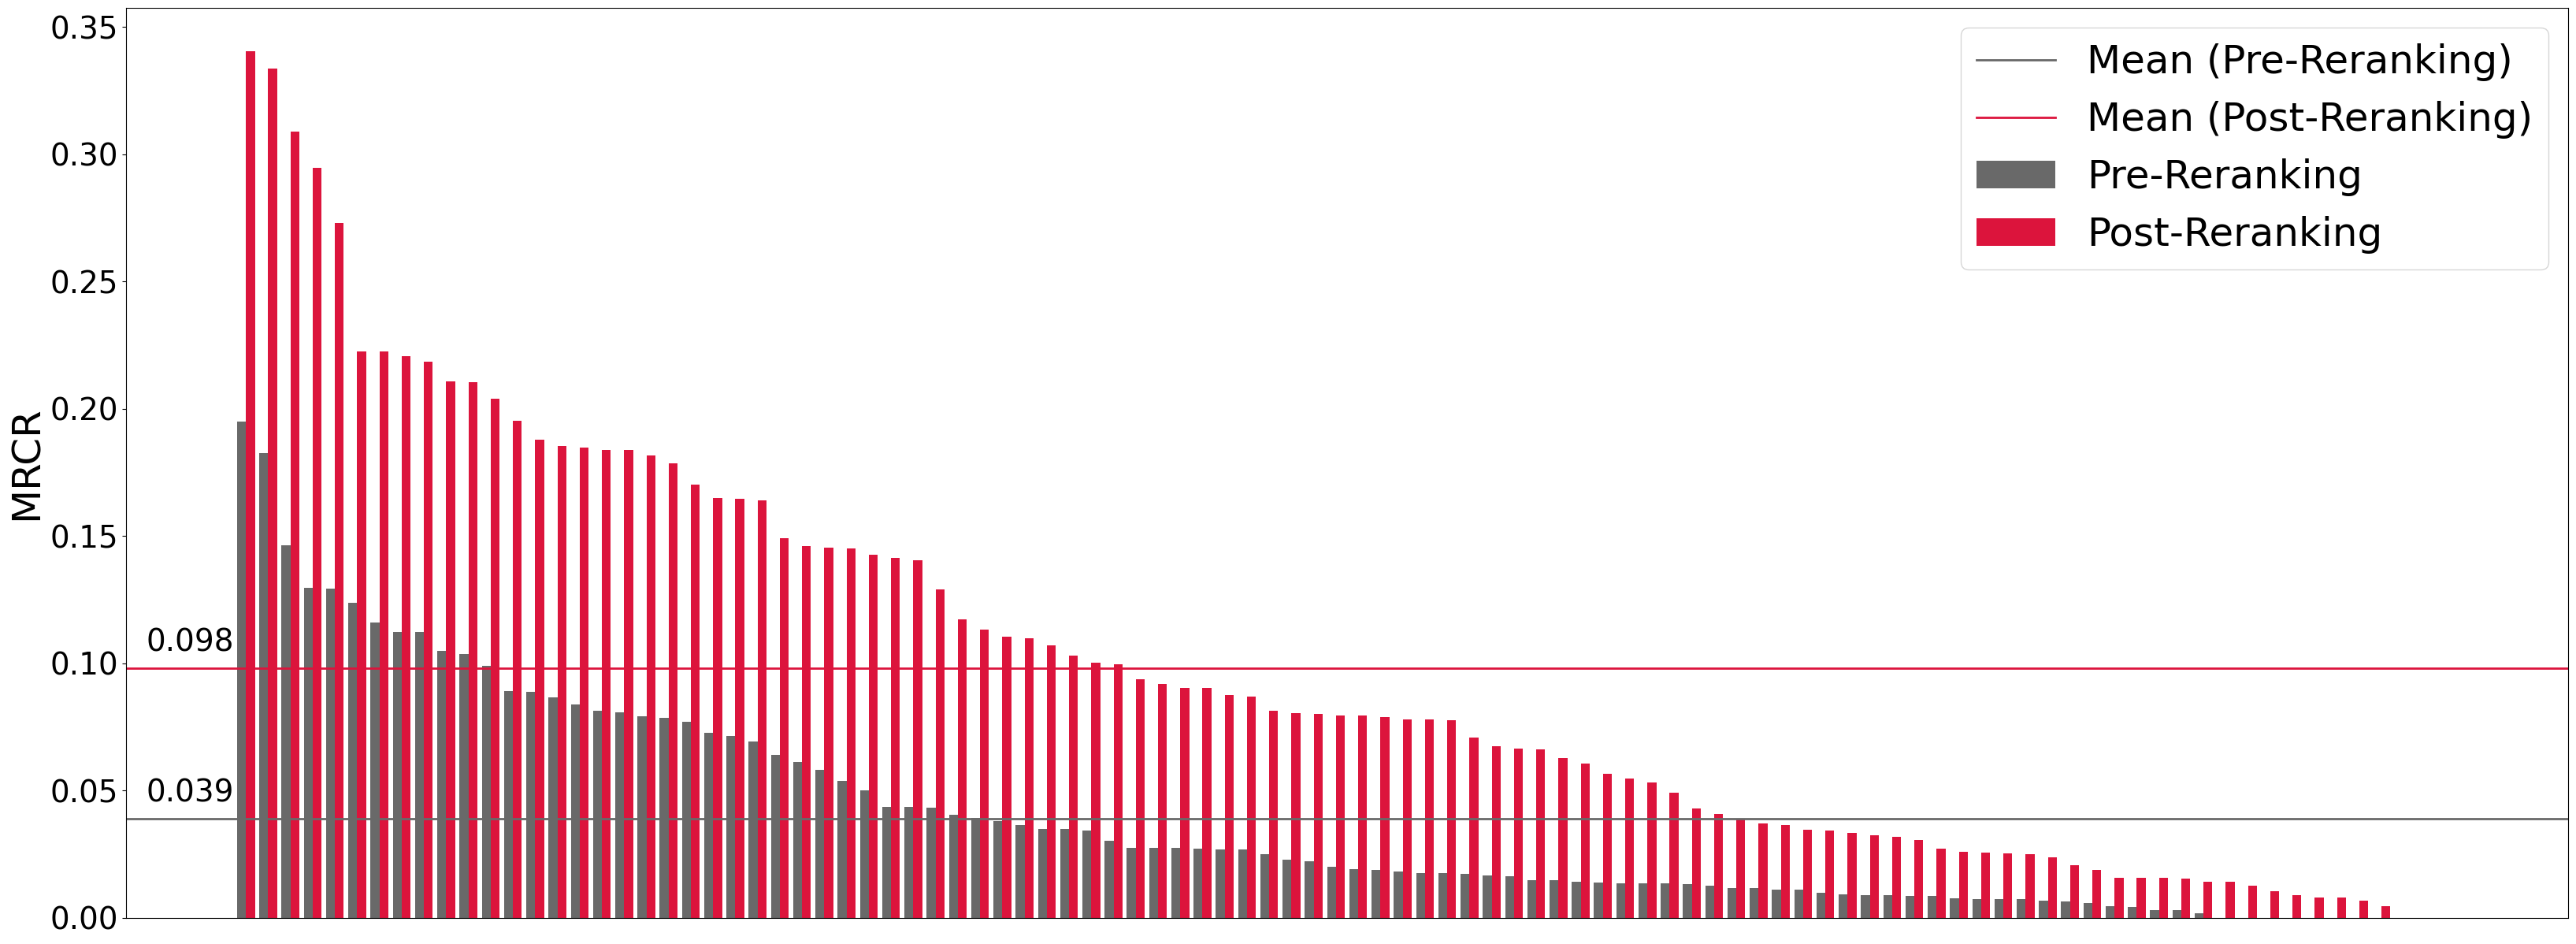

/tmp/ipykernel_60601/2791433123.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


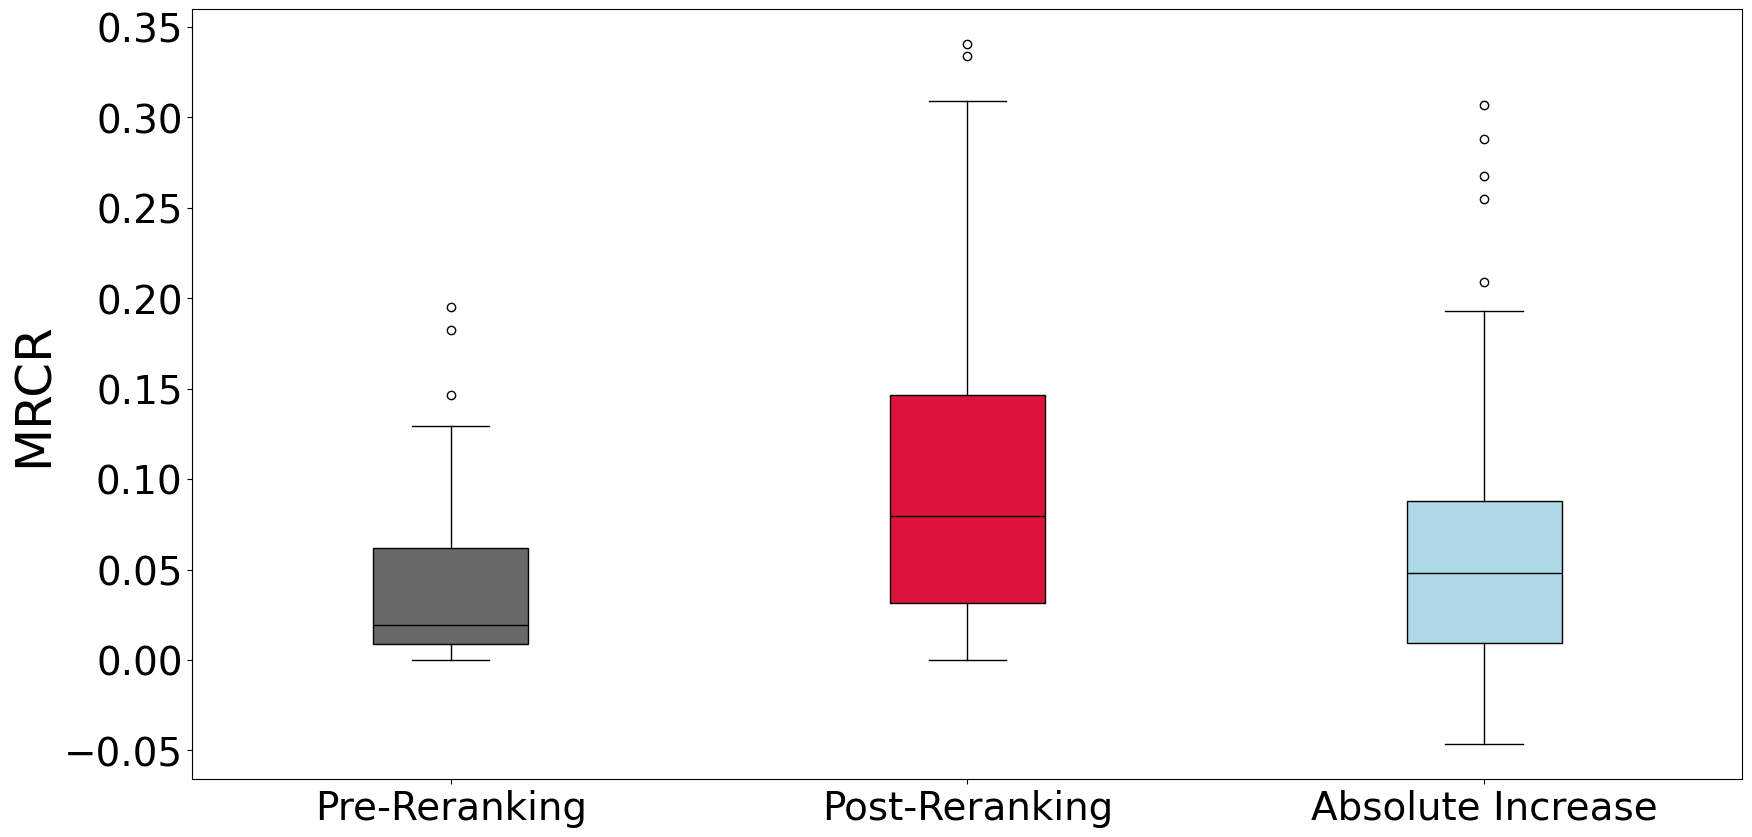

In [39]:
plot_comparison(mean_ratio_common_references_per_run_retrieval, mean_ratio_common_references_per_run_reranking, title="Mean Ratio of Common References", xlabel="Run", ylabel="MRCR")

    ### ratio of common references, per rank
    mean ratio of common references, per rank (ignoring NaN values)
    --> e.g. what is the mean ratio of common references for the top 1 retrieved work (across all runs)

In [41]:
mean_ratio_common_references_per_rank_retrieval = get_mean_ratio_common_references_per_rank(ratio_common_references_retrieval)
mean_ratio_common_references_per_rank_reranking = get_mean_ratio_common_references_per_rank(ratio_common_references_reranking)
mean_ratio_common_references_per_rank_retrieval, mean_ratio_common_references_per_rank_reranking

(array([0.03708939, 0.03395041, 0.04884873, 0.04698782, 0.03238772,
        0.04108161, 0.03383854, 0.04464056, 0.03224711, 0.04584298]),
 array([0.12350967, 0.12766741, 0.12055043, 0.09277569, 0.10178062,
        0.08824499, 0.10402249, 0.09075526, 0.0683477 , 0.07283911]))

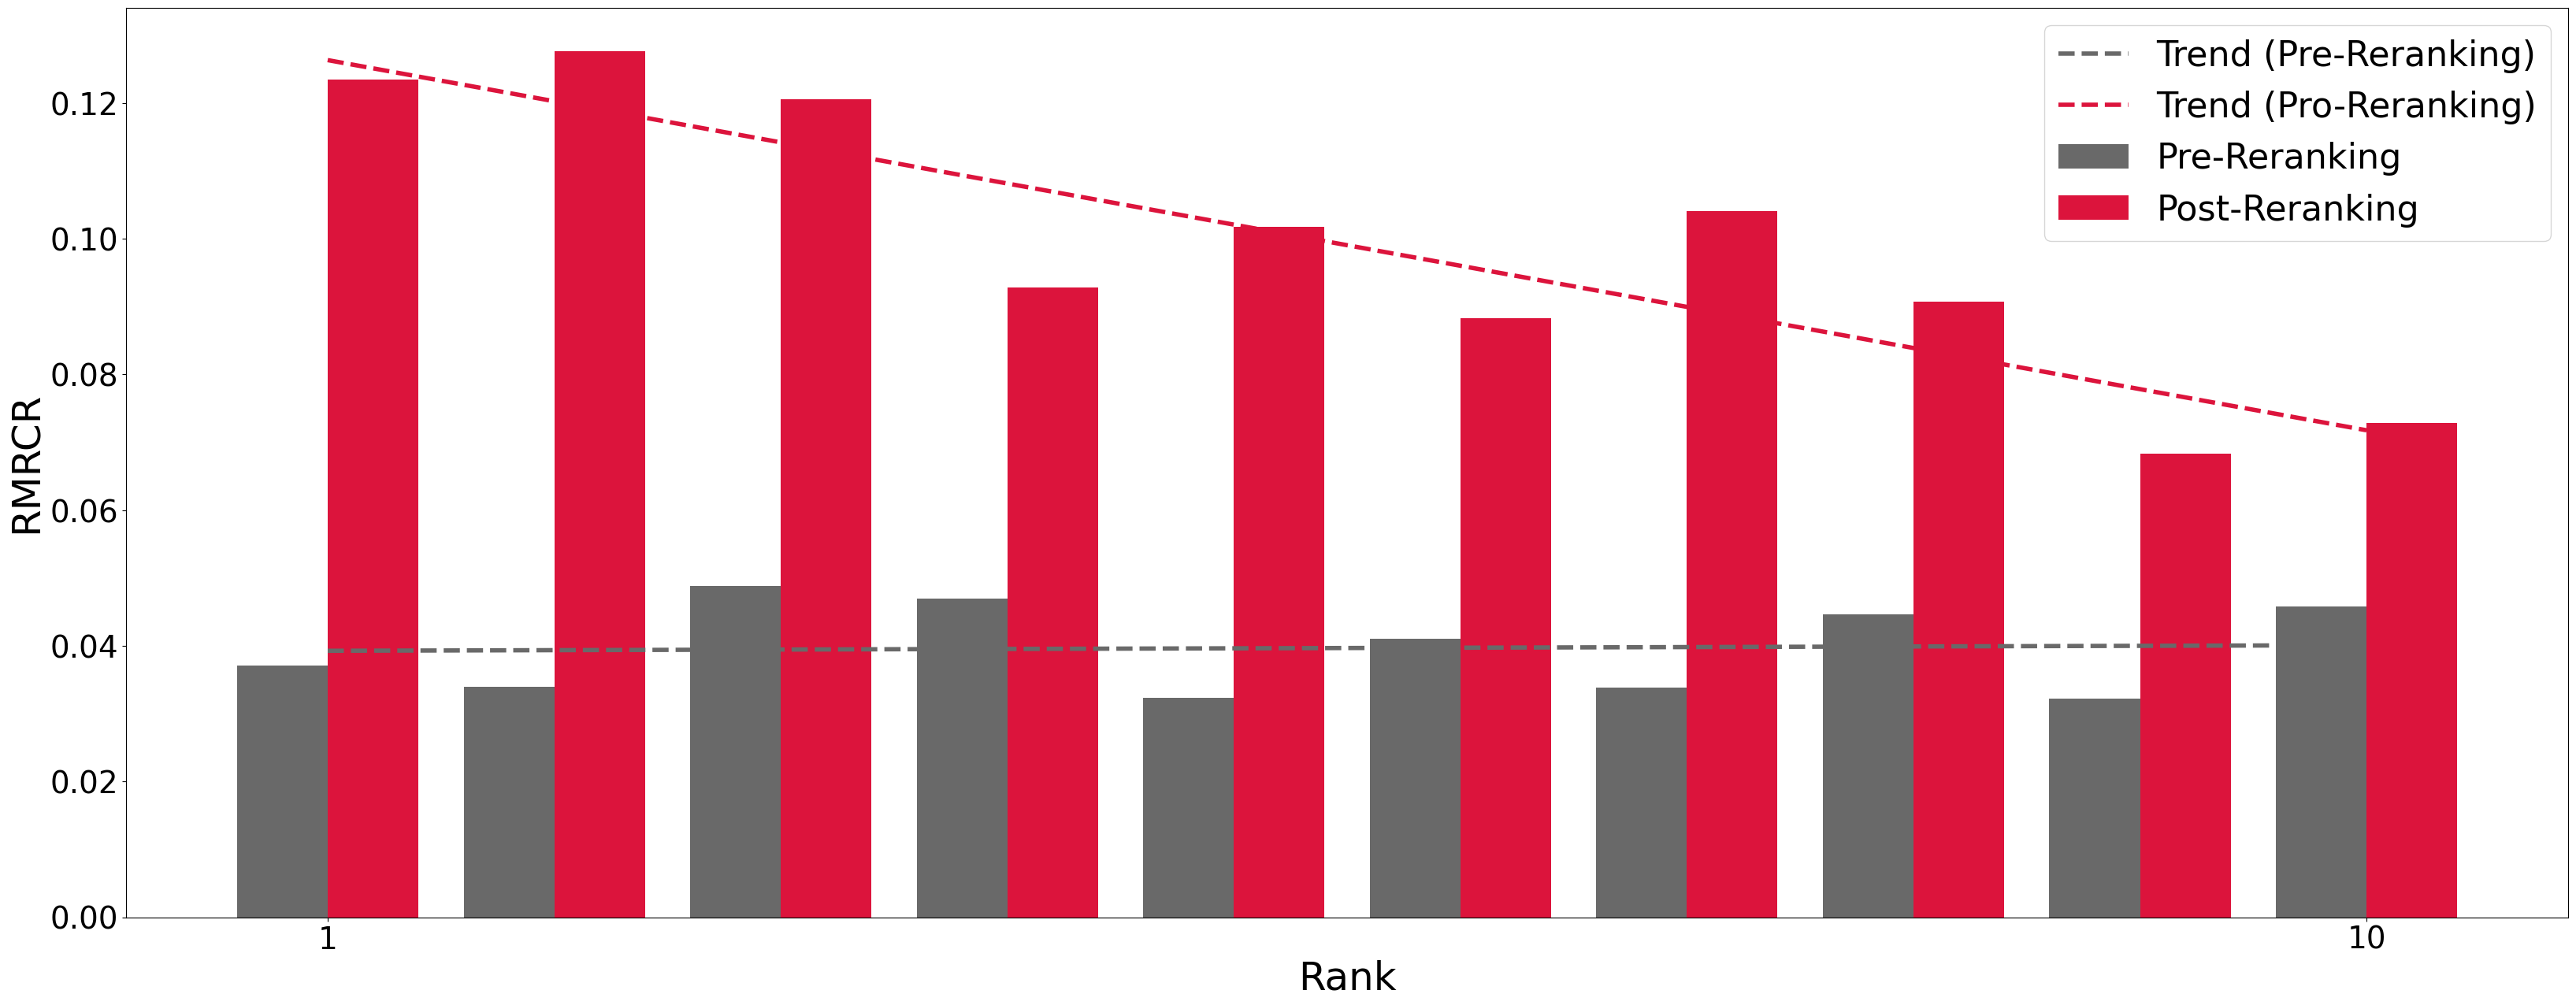

In [42]:
plot_comparison(mean_ratio_common_references_per_rank_retrieval, mean_ratio_common_references_per_rank_reranking, title="Rankwise Mean Ratio of Common References", xlabel="Rank", ylabel="RMRCR")

## mean ratio of common references, total
mean across all runs and ranks

In [19]:
mean_ratio_common_references_total_reranking = get_mean_ratio_common_references_total(ratio_common_references_reranking)
mean_ratio_common_references_total_retrieval = get_mean_ratio_common_references_total(ratio_common_references_retrieval)
mean_ratio_common_references_total_retrieval, mean_ratio_common_references_total_reranking

(0.03970552015052711, 0.09889841796671463)

## median ratio of common references, total
median across all runs and ranks

In [20]:
median_ratio_common_references_total_reranking = get_median_ratio_common_references_total(ratio_common_references_reranking)
median_ratio_common_references_total_retrieval = get_median_ratio_common_references_total(ratio_common_references_retrieval)
median_ratio_common_references_total_retrieval, median_ratio_common_references_total_reranking

(0.0, 0.05064102564102564)